## Install and Import Dependencies

In [1]:
# install wandb
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 7.5 MB/s 
     |████████████████████████████████| 182 kB 52.8 MB/s 
     |████████████████████████████████| 168 kB 43.8 MB/s 
     |████████████████████████████████| 62 kB 401 kB/s 
     |████████████████████████████████| 168 kB 10.9 MB/s 
     |████████████████████████████████| 166 kB 9.1 MB/s 
     |████████████████████████████████| 166 kB 44.7 MB/s 
     |████████████████████████████████| 162 kB 11.7 MB/s 
     |████████████████████████████████| 162 kB 10.5 MB/s 
     |████████████████████████████████| 158 kB 43.8 MB/s 
     |████████████████████████████████| 157 kB 51.6 MB/s 
     |████████████████████████████████| 157 kB 21.4 MB/s 
     |████████████████████████████████| 157 kB 17.7 MB/s 
     |████████████████████████████████| 157 kB 56.3 MB/s 
     |████████████████████████████████| 157 kB 16.9 MB/s 
     |████████████████████████████████| 157 kB 25.0 MB/s 
     |████████████████████████████████| 157 kB 33.9 MB/s 
     |████████████

In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 8.2 MB/s 
     |████████████████████████████████| 46 kB 4.8 MB/s 
     |████████████████████████████████| 66 kB 1.0 MB/s 


In [3]:
# import the necessary packages

import os
import cv2
import joblib
import wandb
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from imutils import paths
from codecarbon import EmissionsTracker
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Fetch and Data Segregation

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "face_mask_detection",
  "artifact_name": "face_mask_raw_data:latest",
}

In [7]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",project=args["project_name"], job_type="feature_extractor")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact face_mask_raw_data:latest, 328.92MB. 11792 files... 
wandb:   11792 of 11792 files downloaded.  
Done. 0:1:48.4
24-11-2022 17:05:01 Path: ./artifacts/face_mask_raw_data:v0


In [8]:
data_dir

'./artifacts/face_mask_raw_data:v0'

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 11792 files belonging to 2 classes.


80% for train and 20% for validation and test

In [10]:
type(raw_wb)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [11]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [12]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 369
Number of train batches: 296
Number of validation batches: 59
Number of test batches: 14


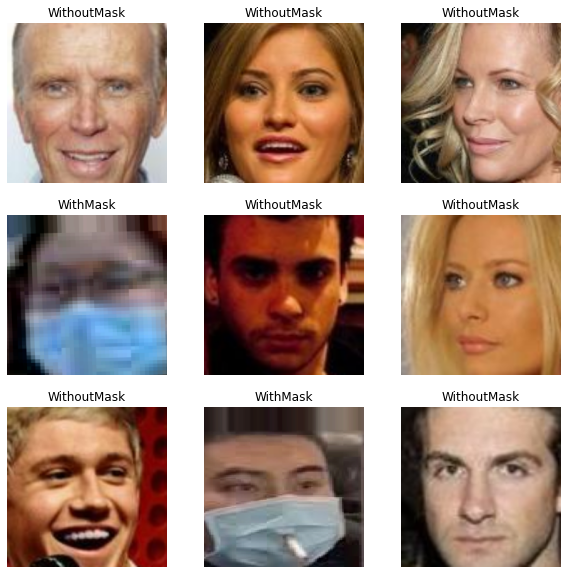

In [13]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

## Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

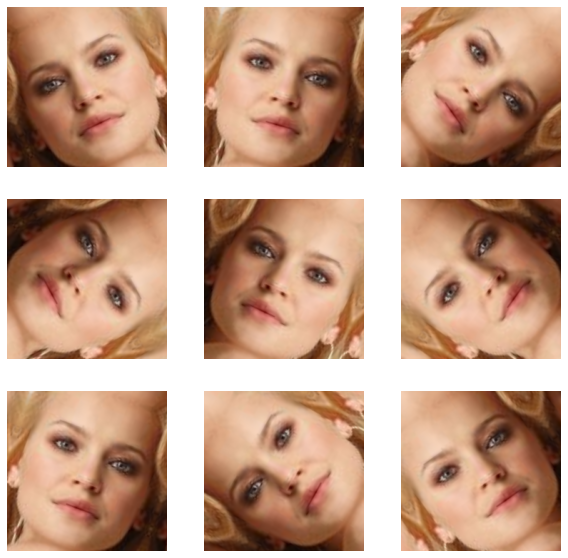

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Create the base model from the pre-trained convnets


<p align='center'>
<img width="800" src="https://drive.google.com/uc?export=view&id=1A16eTvAGc0m2Yev15aAXfOm3myYSQzdH">
</p>

You will create the base model from the [DenseNet201 model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201). This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of DenseNet201 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a DenseNet201 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.




In [17]:
# Create the base model from the pre-trained model DenseNet201
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

74836368/74836368 [==============================] - 0s 0us/step


In [18]:
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

This feature extractor converts each 224x224x3 image into a 7x7x1920 block of features. Let's see what it does to an example batch of images:




In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1920)


## Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. DenseNet291 has many layers, so setting the entire model's trainable flag to False will freeze all of them. This is crucial only in case we are using [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers in the model.

> Many models contain [tf.keras.layers.BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this notebook.

When you set ``layer.trainable = False``, the **BatchNormalization** layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains **BatchNormalization** layers in order to do fine-tuning, you should keep the **BatchNormalization** layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [20]:
model.trainable = False

#### Step 1: Add a classification head

To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a [tf.keras.layers.GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer to convert the features to a single 1920-element vector per image.




In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


Apply a [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer to convert these features into a single prediction per image.

In [22]:
prediction_layer = tf.keras.layers.Dense(2,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


Build a model by chaining together the data augmentation, [tf.keras.applications.densenet.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/preprocess_input), model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use ``training=False`` is only redundant because our models not contains a BatchNormalization layer. However, use it here is important for the sake of understanding. 

In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Step 2: Compile the model

Compile the model before training it.

In [24]:
# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        183219

The 18.325.826 million parameters in DensetNet201 are frozen, but there are 3,842 thousand trainable parameters in the Dense layer. These are divided between two [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) objects, the weights and biases.




In [26]:
len(model.trainable_variables)

2

#### Step 3: Train 

In [27]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

24-11-2022 17:09:18 [INFO] training network...


Epoch 1/20
296/296 [==============================] - 89s 244ms/step - loss: 0.4021 - accuracy: 0.8145 - val_loss: 0.1152 - val_accuracy: 0.9862
Epoch 2/20
296/296 [==============================] - 72s 234ms/step - loss: 0.1195 - accuracy: 0.9700 - val_loss: 0.0497 - val_accuracy: 0.9926
Epoch 3/20
296/296 [==============================] - 71s 229ms/step - loss: 0.0737 - accuracy: 0.9822 - val_loss: 0.0325 - val_accuracy: 0.9942
Epoch 4/20
296/296 [==============================] - 71s 230ms/step - loss: 0.0569 - accuracy: 0.9838 - val_loss: 0.0231 - val_accuracy: 0.9942
Epoch 5/20
296/296 [==============================] - 72s 234ms/step - loss: 0.0441 - accuracy: 0.9878 - val_loss: 0.0181 - val_accuracy: 0.9958
Epoch 6/20
296/296 [==============================] - 71s 230ms/step - loss: 0.0375 - accuracy: 0.9900 - val_loss: 0.0127 - val_accuracy: 0.9974
Epoch 7/20
296/296 [==============================] - 71s 229ms/step - loss: 0.0354 - accuracy: 0.9905 - val_loss: 0.0127 - val_ac

#### Step 4: Metrics for training

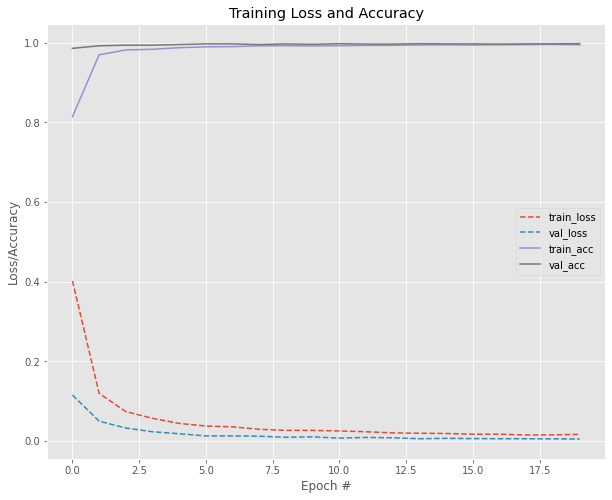

In [28]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [29]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.046118457330415086 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0020108496076939675 kWh
[INFO] Energy consumed for all GPU: 0.026121769053844876 kWh
[INFO] Energy consumed for all CPU: 0.01798583866887622 kWh
[INFO] CO2 emission 0.006398927821682162(in Kg)


Note the dataset is a generator (``tensorflow.python.data.ops.dataset_ops.PrefetchDataset``). Thus, each time you call the dataset object a new (and different) sequence of images will be returned. This is very important to guarantee the same sequence is used in ``model.predict(test_dataset)`` and ``true_labels``. 

#### Step 5: Test and metrics

In [30]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [31]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
14/14 [==============================] - 5s 151ms/step
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       226
 WithoutMask       1.00      1.00      1.00       222

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



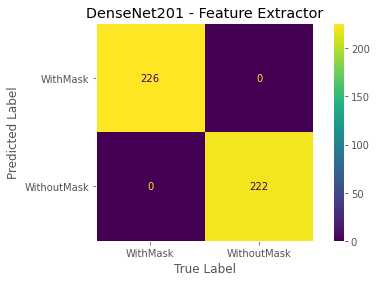

In [32]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_title("DenseNet201 - Feature Extractor")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

#### Step 6: Evaluations metrics for Wandb

In [33]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

24-11-2022 17:34:49 Uploading figures


In [34]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

24-11-2022 17:34:50 Validation Evaluation metrics
24-11-2022 17:34:50 Validation Accuracy: 1.0
24-11-2022 17:34:50 Validation Precision: 1.0
24-11-2022 17:34:50 Validation Recall: 1.0
24-11-2022 17:34:50 Validation F1: 1.0


In [35]:
run.finish()

Acc,1.0
CO2_Emissions,0.0064
Count_Params,18325826
Energy_CPU,0.01799
Energy_Consumed,0.04612
Energy_GPU,0.02612
Energy_RAM,0.00201
F1,1.0
Precision,1.0
Recall,1.0


# Fine-tuning networks

In the previous section we learned how to treat a pre-trained **Convolutional Neural Network** as **feature extractor**. 

> Using this feature extractor, we forward propagated our dataset of images through the network, extracted the activations at a given layer, and saved the values to disk. A shallow machine
learning classifier was then trained on top of the CNN features.

This CNN feature extractor approach, called **transfer learning**, obtained remarkable accuracy, far higher than any of our previous experiments on the Animals dataset.

But there is another type of transfer learning, one that can actually outperform the feature extraction method if you have sufficient data. This method is called **fine-tuning** and **requires us to perform “network surgery”**. 

1. First, we take a **scalpel and cut off the final set of fully-connected layers** (i.e., the “head” of the network) from a pre-trained /Convolutional Neural Network, such as
VGG, ResNet, Inception, so on. 
2. We then **replace the head** with a new set of fully-connected layers with random initializations. From there all layers below the head are frozen so their weights cannot be
updated (i.e., the backward pass in backpropagation does not reach them)
3.  We then train the network **using a very small learning rate** so the new set of FC layers can start to learn patterns from the previously learned CONV layers earlier in the network. 
4. Optionally, we may unfreeze the rest of the network and continue training. Applying fine-tuning allows us to apply pre-trained networks to recognize classes that they were not originally trained on; furthermore, **this method can lead to higher accuracy than feature extraction**.

#### Step 0: Start running project at Wandb

In [36]:
args = {
  "project_name": "face_mask_detection"
}

In [37]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="morsinaldo",
                 project=args["project_name"], 
                 job_type="fine_tuning")

The fine-tuning technique is very similar to the feature extractor, however, instead of just removing the fully connected layer and outputting a feature vector, a new fully connected layer is added, generally simpler than the original one, acting directly as a classifier. The network training using this technique is divided into two stages: initially, all layers of the pre-trained model are frozen (that is, their weights and biases are not trainable), only the new fully connected layer is unfrozen, and there is the first stage of training. Then all or some layers of the pre-trained model are thawed and there is a second training step with this new configuration.

#### Step 1: Organizing Indexes and Layers

Prior to performing **network surgery**, we need to know the **layer name and index** of every layer in a given deep learning model. We need this information as we’ll be required to **“freeze”** and **“unfreeze”** certain layers in a pre-trained CNN.

Without knowing the layer names and indexes ahead of time, we would be “cutting blindly”, an out-of-control surgeon with no game plan. **If we instead take a few minutes to examine the network architecture and implementation, we can better prepare for our surgery.**

In [38]:
# import the necessary packages
from tensorflow.keras.applications import DenseNet201

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = DenseNet201(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	BatchNormalization
[INFO] 8	Activation
[INFO] 9	Conv2D
[INFO] 10	BatchNormalization
[INFO] 11	Activation
[INFO] 12	Conv2D
[INFO] 13	Concatenate
[INFO] 14	BatchNormalization
[INFO] 15	Activation
[INFO] 16	Conv2D
[INFO] 17	BatchNormalization
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	Concatenate
[INFO] 21	BatchNormalization
[INFO] 22	Activation
[INFO] 23	Conv2D
[INFO] 24	BatchNormalization
[INFO] 25	Activation
[INFO] 26	Conv2D
[INFO] 27	Concatenate
[INFO] 28	BatchNormalization
[INFO] 29	Activation
[INFO] 30	Conv2D
[INFO] 31	BatchNormalization
[INFO] 32	Activation
[INFO] 33	Conv2D
[INFO] 34	Concatenate
[INFO] 35	BatchNormalization
[INFO] 36	Activation
[INFO] 37	Conv2D
[INFO] 38	BatchNormalization
[INFO] 39	Activation
[INFO] 40	Conv2D
[INFO] 41	Concatenate
[INFO] 42	BatchNorma

Before we can replace the head of a pre-trained CNN, we need something to replace it with – therefore, we need to define our own fully-connected head of the network.

In [39]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

Again, this fully-connected head is very simplistic compared to the original head from DenseNet201. However, for most fine-tuning problems you are not seeking to replicate the original head of the network, but rather simplify it so it is easier to fine-tune– the fewer parameters in the head, the more likely we’ll be to correctly tune the network to a new
classification task.


In some cases you’ll want to allow the entire body to be trainable; however, **for deeper architectures with many parameters such as DenseNet, I suggest only unfreezing the top CONV layers and then continuing training**. If classification accuracy continues to improve (without overfitting), you may want to consider unfreezing more layers in the body.

#### Step 2: First Stage of training

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [41]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [42]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.densenet.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [43]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                           

In [44]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [45]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [46]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                           

In [47]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	TFOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	TFOpLambda
[INFO] 5	Functional
[INFO] 6	Flatten
[INFO] 7	Dense
[INFO] 8	Dropout
[INFO] 9	Dense


In [48]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[:6]:
	layer.trainable = False

In [49]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                           

In [50]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [51]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=3,
                    verbose=1)

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training head...
Epoch 1/3
296/296 [==============================] - 86s 244ms/step - loss: 0.1197 - accuracy: 0.9818 - val_loss: 0.0149 - val_accuracy: 0.9974
Epoch 2/3
296/296 [==============================] - 73s 235ms/step - loss: 0.0640 - accuracy: 0.9927 - val_loss: 0.0036 - val_accuracy: 0.9984
Epoch 3/3
296/296 [==============================] - 74s 235ms/step - loss: 0.0315 - accuracy: 0.9952 - val_loss: 0.1191 - val_accuracy: 0.9910


#### Step 3: Second stage of training

As we already had excellent results in the first stage, there is no need to run the second one.

#### Step 4: Metrics for training

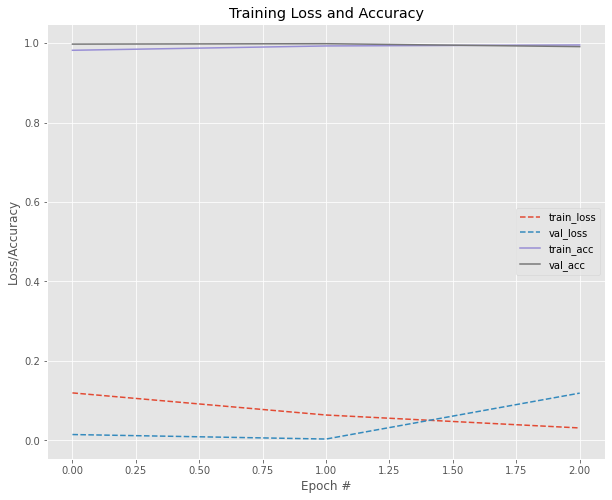

In [52]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 3), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 3), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 3), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 3), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [53]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.0071650179697571315 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00030786735237606233 kWh
[INFO] Energy consumed for all GPU: 0.004102907000124587 kWh
[INFO] Energy consumed for all CPU: 0.0027542436172564824 kWh
[INFO] CO2 emission 0.0009941449797648487(in Kg)


#### Step 5: Test and metrics

In [54]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [55]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names, digits=4))

[INFO] evaluating network...
14/14 [==============================] - 5s 149ms/step
              precision    recall  f1-score   support

    WithMask     0.9731    1.0000    0.9864       217
 WithoutMask     1.0000    0.9740    0.9868       231

    accuracy                         0.9866       448
   macro avg     0.9865    0.9870    0.9866       448
weighted avg     0.9870    0.9866    0.9866       448



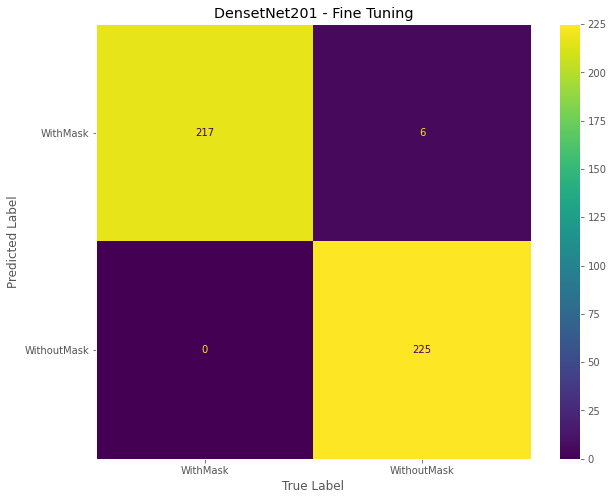

In [56]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_title("DensetNet201 - Fine Tuning")
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

#### Step 6: Evaluations metrics for Wandb

In [57]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

24-11-2022 17:40:03 Uploading figures


In [58]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

24-11-2022 17:40:03 Validation Evaluation metrics
24-11-2022 17:40:03 Validation Accuracy: 0.9866071428571429
24-11-2022 17:40:03 Validation Precision: 0.9869674887892377
24-11-2022 17:40:03 Validation Recall: 0.9866071428571429
24-11-2022 17:40:03 Validation F1: 0.9866103468899521


In [59]:
run.finish()

Acc,0.98661
CO2_Emissions,0.00099
Count_Params,42407234
Energy_CPU,0.00275
Energy_Consumed,0.00717
Energy_GPU,0.0041
Energy_RAM,0.00031
F1,0.98661
Precision,0.98697
Recall,0.98661
